In [141]:
from datetime import date
today = date.today()

In [142]:
#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '1993-01-01'
date_end = today.strftime("%Y-%m-%d")

In [143]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [144]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], 
                       start=date_start, 
                       end=date_end, 
                       data_source='yahoo')
    name = stock[i]
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
        
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [145]:
combined_data

,SPY
Date,
1993-01-29,25.968958
1993-02-01,26.153660
1993-02-02,26.209057
1993-02-03,26.486113
1993-02-04,26.596937
...,...
2021-02-25,382.329987
2021-02-26,380.359985
2021-03-01,389.579987


<AxesSubplot:xlabel='Date'>

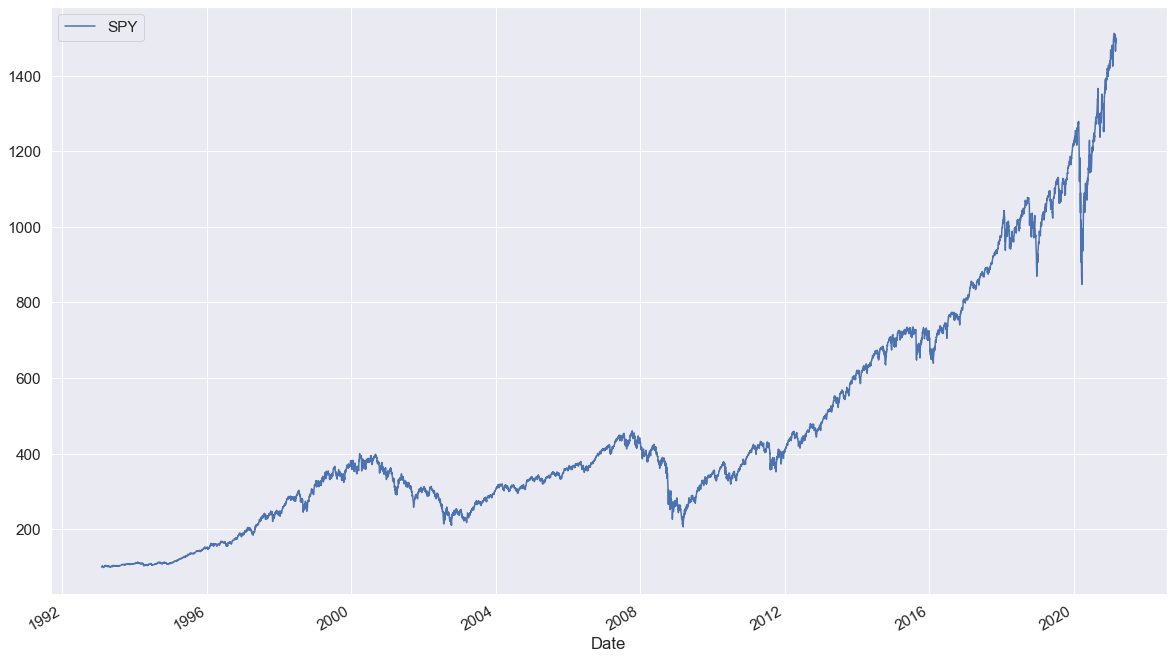

In [146]:
(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [147]:
combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data.dropna(inplace=True)
combined_data.tail()

,SPY,return,direction
Date,,,
2021-02-25,382.329987,-0.024391,0
2021-02-26,380.359985,-0.005166,0
2021-03-01,389.579987,0.023951,1
2021-03-02,386.540009,-0.007834,0
2021-03-03,386.035004,-0.001307,0


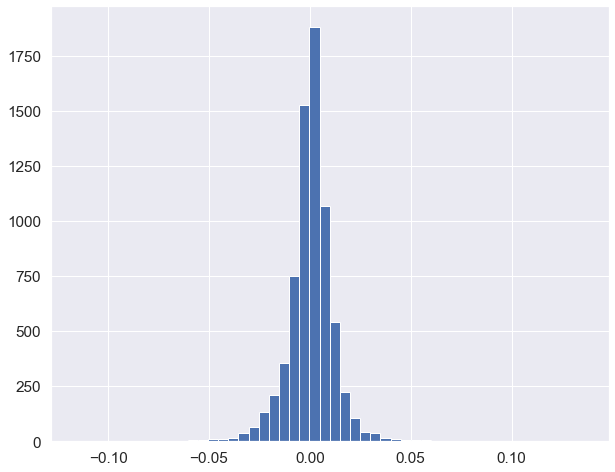

In [101]:
combined_data['return'].hist(bins=50, figsize=(10, 8));

# Feature Engineering

In [104]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

In [105]:
import ta
from ta.volatility import BollingerBands

In [106]:
indicator_bb = BollingerBands(close=combined_data['SPY'], window=20, window_dev=2)
combined_data['bb_bbm'] = indicator_bb.bollinger_mavg()
combined_data['bb_bbh'] = indicator_bb.bollinger_hband()
combined_data['bb_bbl'] = indicator_bb.bollinger_lband()

In [107]:
from ta.trend import MACD

In [108]:
indicator_macd = MACD(close = combined_data['SPY'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
combined_data['macd'] = indicator_macd.macd()
combined_data['macd_diff'] = indicator_macd.macd_diff()
combined_data['macd_signal'] = indicator_macd.macd_signal()

In [109]:
combined_data['momentum'] = combined_data['return'].rolling(5).mean().shift(1)
combined_data['volatility'] = combined_data['return'].rolling(20).std().shift(1)
combined_data['distance'] = (combined_data[stock] - combined_data[stock].rolling(50).mean()).shift(1)

In [110]:
combined_data.dropna(inplace=True)
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-28,25.998814,-0.002139,0,0.010742,-0.007889,-0.004276,-0.012721,-0.000703,26.386663,26.984872,25.788454,-0.134615,-0.075668,-0.058947,-0.002969,0.007520,-0.393977
1993-04-29,26.110176,0.004274,1,-0.002139,0.010742,-0.007889,-0.004276,-0.012721,26.350477,26.923103,25.777851,-0.133862,-0.059932,-0.073930,-0.003257,0.007458,-0.455796
1993-04-30,26.147274,0.001420,1,0.004274,-0.002139,0.010742,-0.007889,-0.004276,26.320786,26.870436,25.771136,-0.128788,-0.043886,-0.084902,0.000142,0.007572,-0.353168
1993-05-03,26.314287,0.006367,1,0.001420,0.004274,-0.002139,0.010742,-0.007889,26.327280,26.873389,25.781172,-0.110022,-0.020096,-0.089926,0.001282,0.007580,-0.325917
1993-05-04,26.407076,0.003520,1,0.006367,0.001420,0.004274,-0.002139,0.010742,26.331920,26.879083,25.784756,-0.086663,0.002610,-0.089273,0.004133,0.006128,-0.170243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,386.078500,399.272681,372.884319,3.510671,-0.434931,3.945602,-0.002462,0.009920,9.025182
2021-02-25,382.329987,-0.024391,0,0.010959,0.001214,-0.007721,-0.001768,-0.004265,386.474500,398.682639,374.266360,2.722356,-0.978597,3.700953,-0.000316,0.010181,12.763240
2021-02-26,380.359985,-0.005166,0,-0.024391,0.010959,0.001214,-0.007721,-0.001768,386.610999,398.476772,374.745225,1.916554,-1.427519,3.344073,-0.004341,0.010134,2.971542


<AxesSubplot:xlabel='Date'>

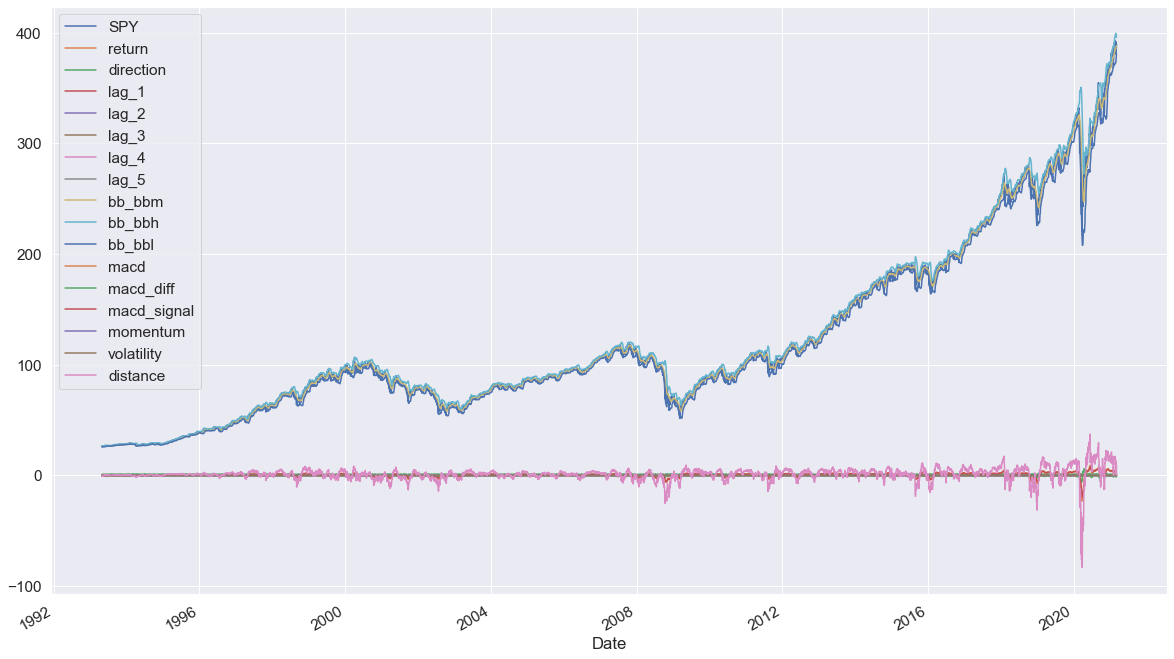

In [111]:
combined_data.plot(figsize=(20, 12))

# Which columns to use for training

In [112]:
cols = list(combined_data.columns)

In [113]:
cols = cols[3:]
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'macd',
 'macd_diff',
 'macd_signal',
 'momentum',
 'volatility',
 'distance']

In [114]:
X = combined_data[cols]

In [115]:
y = combined_data['direction']

In [116]:
split = int(0.7*len(combined_data))

In [117]:
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [118]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [119]:
model = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=10000)

In [120]:
model = model.fit (X_train,y_train)

In [121]:
model.score(X_test, y_test)

0.6449619771863118

In [122]:
cross_val = cross_val_score(linear_model.LogisticRegression(), X, y, scoring='accuracy', cv=10)
cross_val
cross_val.mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.6314847328399397

In [123]:
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-28,25.998814,-0.002139,0,0.010742,-0.007889,-0.004276,-0.012721,-0.000703,26.386663,26.984872,25.788454,-0.134615,-0.075668,-0.058947,-0.002969,0.007520,-0.393977
1993-04-29,26.110176,0.004274,1,-0.002139,0.010742,-0.007889,-0.004276,-0.012721,26.350477,26.923103,25.777851,-0.133862,-0.059932,-0.073930,-0.003257,0.007458,-0.455796
1993-04-30,26.147274,0.001420,1,0.004274,-0.002139,0.010742,-0.007889,-0.004276,26.320786,26.870436,25.771136,-0.128788,-0.043886,-0.084902,0.000142,0.007572,-0.353168
1993-05-03,26.314287,0.006367,1,0.001420,0.004274,-0.002139,0.010742,-0.007889,26.327280,26.873389,25.781172,-0.110022,-0.020096,-0.089926,0.001282,0.007580,-0.325917
1993-05-04,26.407076,0.003520,1,0.006367,0.001420,0.004274,-0.002139,0.010742,26.331920,26.879083,25.784756,-0.086663,0.002610,-0.089273,0.004133,0.006128,-0.170243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,386.078500,399.272681,372.884319,3.510671,-0.434931,3.945602,-0.002462,0.009920,9.025182
2021-02-25,382.329987,-0.024391,0,0.010959,0.001214,-0.007721,-0.001768,-0.004265,386.474500,398.682639,374.266360,2.722356,-0.978597,3.700953,-0.000316,0.010181,12.763240
2021-02-26,380.359985,-0.005166,0,-0.024391,0.010959,0.001214,-0.007721,-0.001768,386.610999,398.476772,374.745225,1.916554,-1.427519,3.344073,-0.004341,0.010134,2.971542


In [124]:
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.61      0.54      0.57       931
           1       0.67      0.73      0.70      1173

    accuracy                           0.64      2104
   macro avg       0.64      0.63      0.63      2104
weighted avg       0.64      0.64      0.64      2104



In [125]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

Confusion Matrix
[[1174 1113]
 [ 650 1971]]

Accuracy
0.6407905460472698


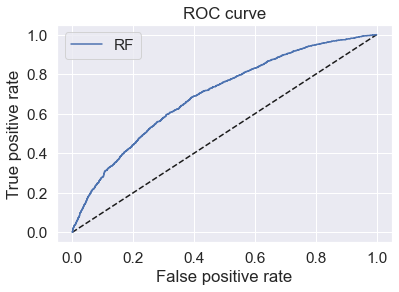

In [127]:
# Performance Metrics
y_pred_rf = model.predict_proba(X_train)[:, 1]
y_pred = model.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.54      0.57       931
           1       0.67      0.73      0.70      1173

    accuracy                           0.64      2104
   macro avg       0.64      0.63      0.63      2104
weighted avg       0.64      0.64      0.64      2104

Confusion Matrix
[[502 429]
 [318 855]]

Accuracy
0.6449619771863118


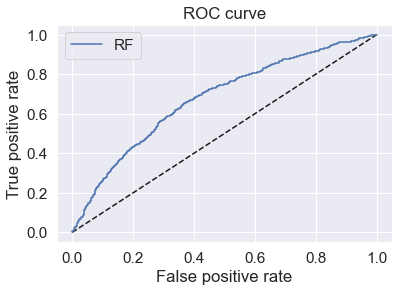

In [130]:
# Performance Metrics
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [131]:
combined_data['Predicted_Signal'] = model.predict(X)
combined_data['Original_SP_returns'] = combined_data['return']
Cumulative_originalSP500_returns = np.cumsum(combined_data[split:]['Original_SP_returns']).apply(np.exp)
combined_data['Strategy_Returns'] = combined_data['Original_SP_returns']* combined_data['Predicted_Signal']
Cumulative_Strategy_returns = np.cumsum(combined_data[split:]['Strategy_Returns']).apply(np.exp)

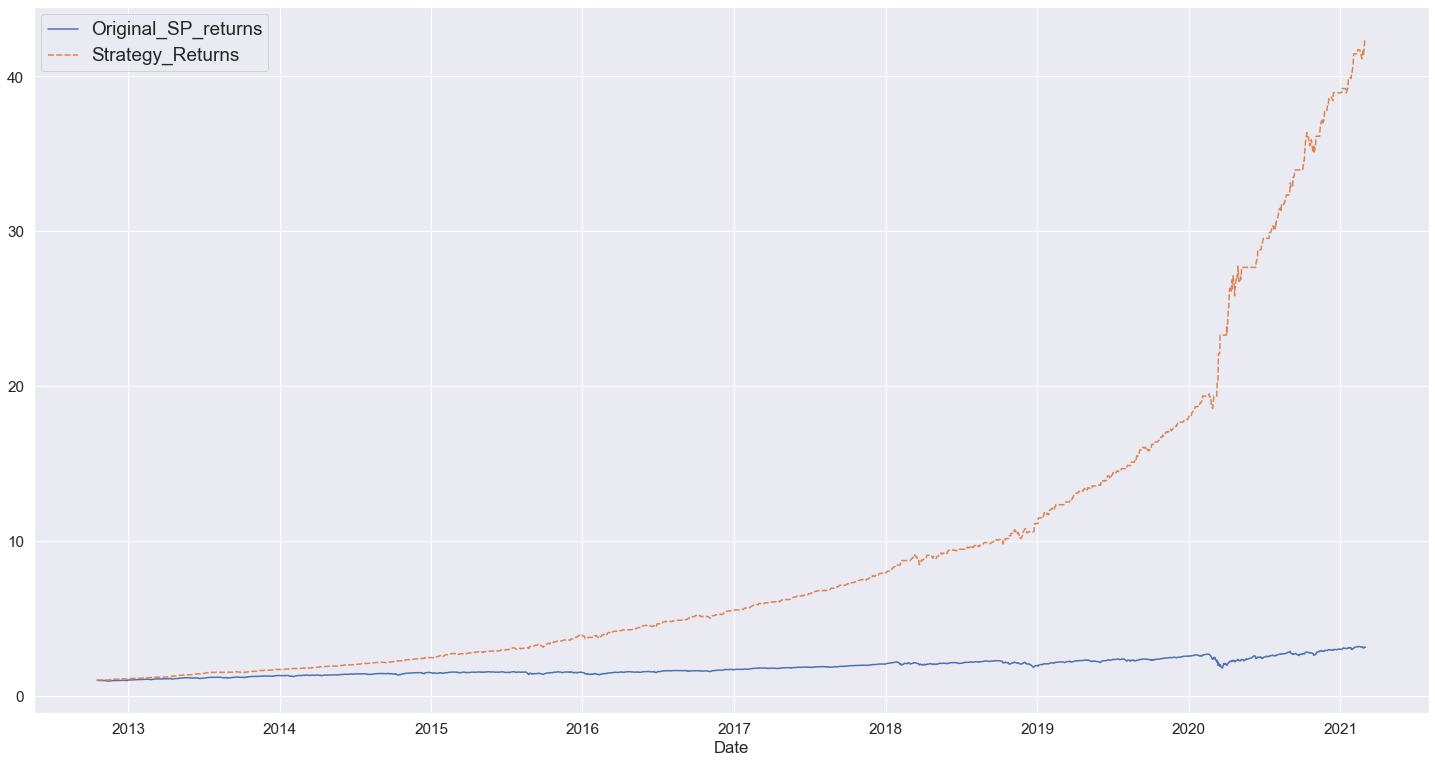

In [132]:
newdf = pd.concat([Cumulative_originalSP500_returns, Cumulative_Strategy_returns], axis=1)
 
 
#Graph plotting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
 
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)

In [133]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,2013-01-02
End date,2021-03-02
Total months,97
,Backtest
Annual return,56.153%
Cumulative returns,3687.506%
Annual volatility,10.419%
Sharpe ratio,4.33
Calmar ratio,7.97
Stability,0.99
Max drawdown,-7.043%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.04,2018-03-12,2018-03-23,2018-05-10,44
1,6.86,2015-12-30,2016-01-08,2016-02-22,39
2,5.65,2015-09-16,2015-09-28,2015-10-07,16
3,5.28,2018-11-09,2018-11-23,2018-12-03,17
4,4.84,2020-02-20,2020-02-28,2020-03-10,14


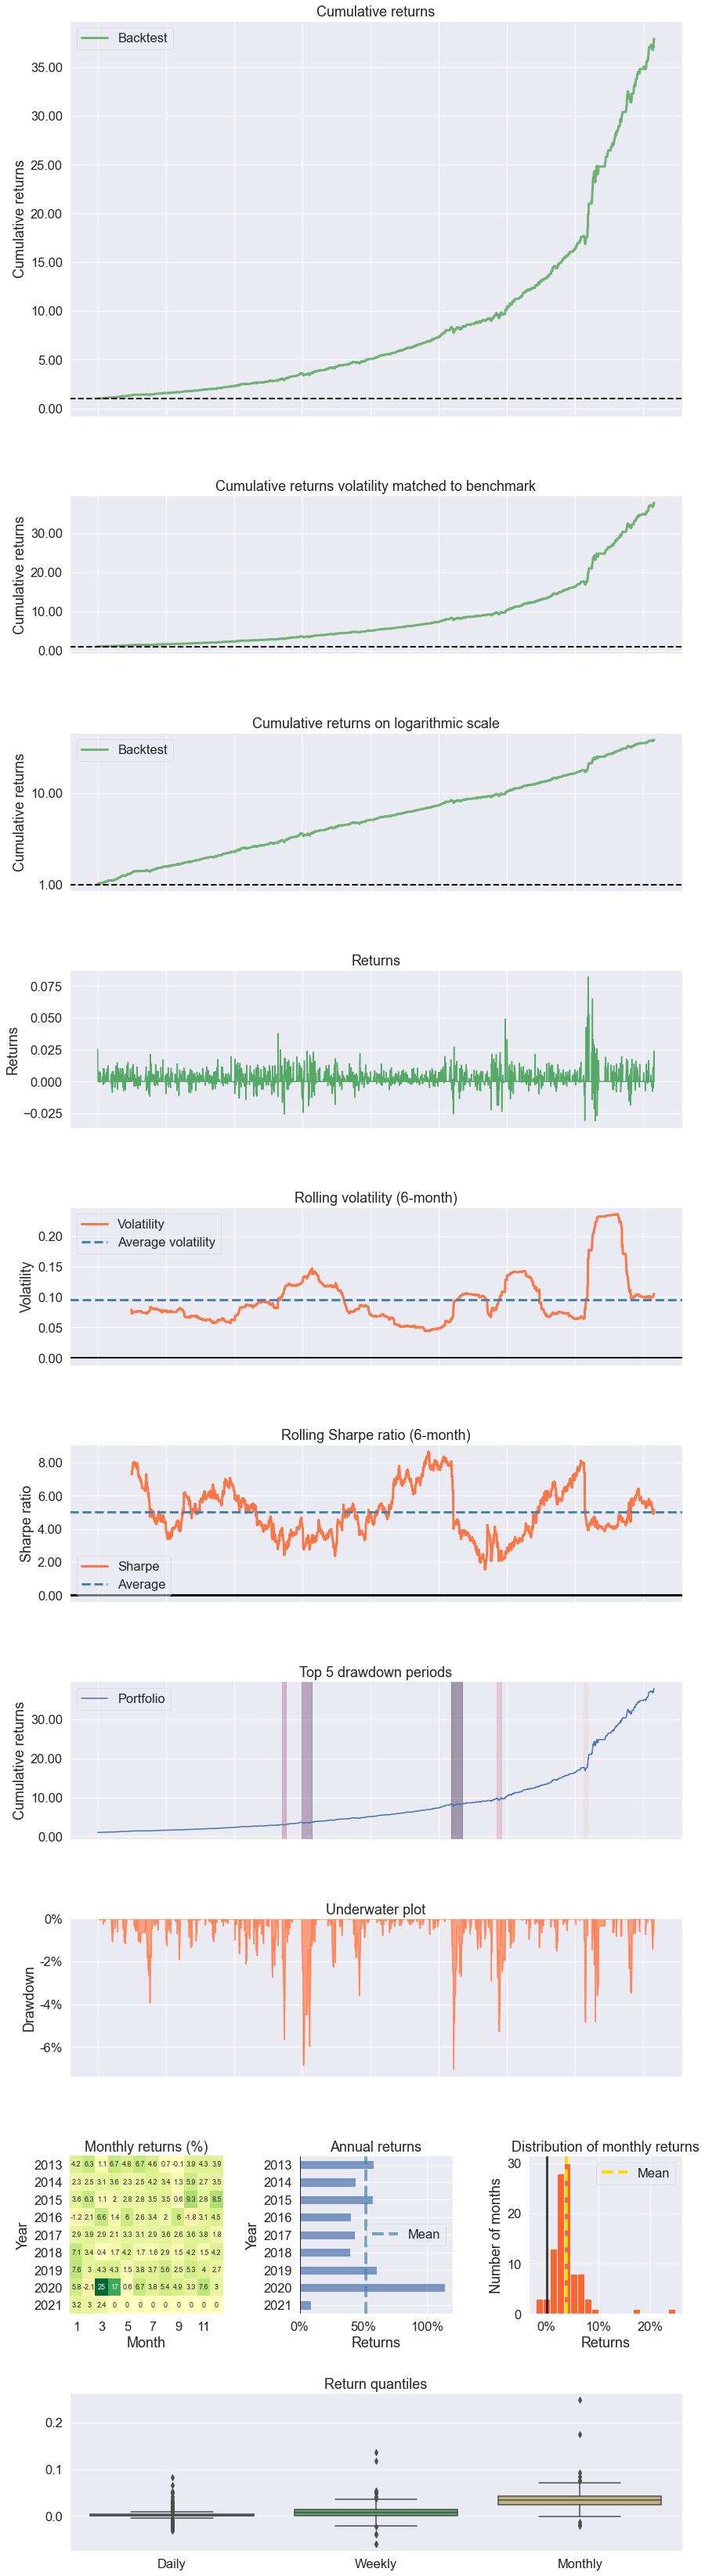

In [134]:
meta_returns = combined_data['Strategy_Returns'].loc['20130102':]
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)

In [135]:
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.metrics import auc


def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

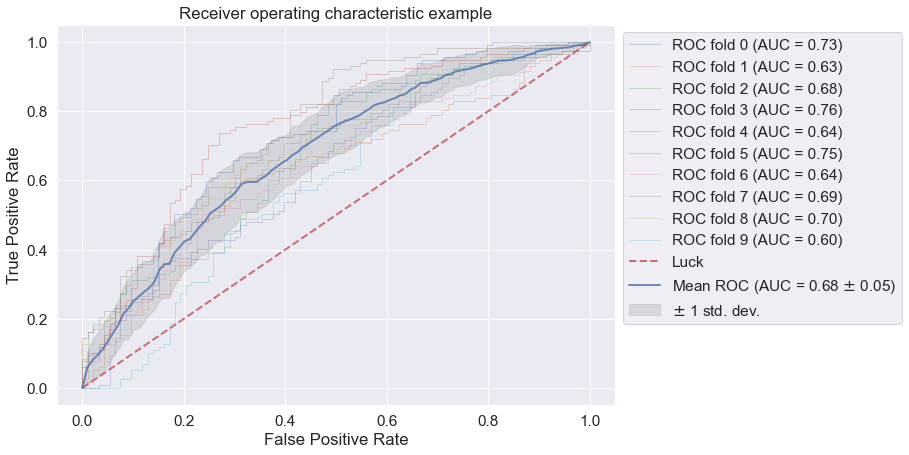

In [137]:
skf = StratifiedKFold(n_splits=10, shuffle=False)
model = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=10000)
crossValPlot(skf,model,X_test,y_test)